# Group 10 project: Stroke Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay


# Stage III: Machine Learning Models
---

## III.1 Hypothesis Verification

In [2]:
df = pd.read_csv("Data/newdata.csv")
nfeatures = ["bmi", "age", "avg_glucose_level"]
cfeatures = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

### III.1.a Rewrite the hypotheses:

#### **Hypothesis 1: Average Glucose Level and Stroke Risk**
- **Null (H₀):** There is **no significant** relationship between average glucose level and stroke occurrence.  
- **Alternative (H₁):** Higher average glucose levels can lead to **higher chance** of having a stroke.  

#### **Hypothesis 2: BMI and Stroke Risk**
- **Null (H₀):** BMI has **no significant** effect on the chance of having a stroke.  
- **Alternative (H₁):** Higher BMI might associate with **higher chance** of stroke.  

#### **Hypothesis 3: Age and Stroke Risk**
- **Null (H₀):** There is **no significant** relationship between age and stroke occurrence.  
- **Alternative (H₁):** Older individuals have a **higher chance** of experiencing a stroke. 

### III.1.b Justify an approporiate test:

#### Since all 3 independent variables are continuous numerical variables, we will select the Pearson correlation test.
#### This test will evaluates whether there is a significant relationship between each variables(avg_glucose_level, BMI, Age)
#### and stroke occurence.

### III.1.c Report:

In [3]:
# significance level
alpha = 0.05

def decision(p):
    return "Reject H0" if p <= alpha else "Fail to reject H0"

hyp_results = []

# Avg glucose vs stroke
r_gluc, p_gluc = stats.pointbiserialr(df["avg_glucose_level"], df["stroke"])
tstat_gluc, p_t_gluc = stats.ttest_ind(
    df.loc[df["stroke"]==1,"avg_glucose_level"],
    df.loc[df["stroke"]==0,"avg_glucose_level"],
    equal_var=False)
hyp_results.append(("Avg glucose (r)", r_gluc, p_gluc, decision(p_gluc)))
hyp_results.append(("Avg glucose (t)", tstat_gluc, p_t_gluc, decision(p_t_gluc)))

# BMI vs stroke
r_bmi, p_bmi = stats.pointbiserialr(df["bmi"], df["stroke"])
tstat_bmi, p_t_bmi = stats.ttest_ind(
    df.loc[df["stroke"]==1,"bmi"],
    df.loc[df["stroke"]==0,"bmi"],
    equal_var=False)
hyp_results.append(("BMI (r)", r_bmi, p_bmi, decision(p_bmi)))
hyp_results.append(("BMI (t)", tstat_bmi, p_t_bmi, decision(p_t_bmi)))

# Age vs stroke
r_age, p_age = stats.pointbiserialr(df["age"], df["stroke"])
tstat_age, p_t_age = stats.ttest_ind(
    df.loc[df["stroke"]==1,"age"],
    df.loc[df["stroke"]==0,"age"],
    equal_var=False)
hyp_results.append(("Age (r)", r_age, p_age, decision(p_age)))
hyp_results.append(("Age (t)", tstat_age, p_t_age, decision(p_t_age)))

pd.DataFrame(hyp_results, columns=["Test","Statistic","p_value","Decision"])
df_results = pd.DataFrame(hyp_results, columns=["Test","Statistic","p_value","Decision"])
df_results["Statistic"] = df_results["Statistic"].round(2)
df_results["p_value"] = df_results["p_value"]
df_results

,Test,Statistic,p_value,Decision
0,Avg glucose (r),0.13,2.705303e-21,Reject H0
1,Avg glucose (t),6.98,2.373124e-11,Reject H0
2,BMI (r),0.04,3.738928e-03,Reject H0
3,BMI (t),3.70,2.562654e-04,Reject H0
4,Age (r),0.25,7.435469e-71,Reject H0
5,Age (t),29.68,2.175773e-95,Reject H0


Based on the p-values (all < 0.05), we **Reject H₀** for all three variables:

| Variable | Decision | Interpretation |
|---------|----------|----------------|
| Avg Glucose | Reject H₀ | Higher glucose levels are significantly associated with higher stroke risk |
| BMI | Reject H₀ | Higher BMI shows a significant relationship with stroke risk |
| Age | Reject H₀ | Older age is strongly associated with stroke risk |

### Conclusion
The hypothesis testing results show that all three predictors — **age**, **average glucose level**, and **BMI** — have statistically significant relationships with stroke occurrence. In each case, the p-value was far below the significance threshold (α = 0.05), leading us to **reject the null hypothesis** for all variables.

## III.2 Machine Learning Exploration

## **Addressing the imbalance dataset problem**

In [4]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.0,67.0,0,1,1,0,0,228.69,36.600,1,1
1,1.0,61.0,0,0,1,1,1,202.21,34.650,0,1
2,0.0,80.0,0,1,1,0,1,105.92,32.500,0,1
3,1.0,49.0,0,0,1,0,0,171.23,34.400,2,1
4,1.0,79.0,1,0,1,1,1,174.12,24.000,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,1.0,80.0,1,0,1,0,0,83.75,27.175,0,0
5105,1.0,81.0,0,0,1,1,0,125.20,40.000,0,0
5106,1.0,35.0,0,0,1,1,1,82.99,30.600,0,0
5107,0.0,51.0,0,0,1,0,1,166.29,25.600,1,0


In [5]:
df['stroke'].value_counts().to_frame()

,count
stroke,
0,4860
1,249


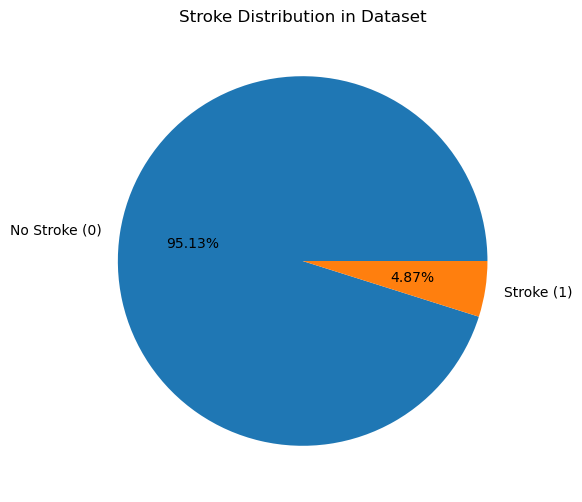

In [6]:
stroke_counts = df['stroke'].value_counts()

labels = ['No Stroke (0)', 'Stroke (1)']

#Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(stroke_counts, labels=labels, autopct='%.2f%%')
plt.title('Stroke Distribution in Dataset')
plt.show()

### Interpretation

Our dataset is highly imbalanced:

- **No Stroke:** ~95%
- **Stroke:** ~5%

This means the model has way more "no-stroke" cases than actual stroke cases.  
As a result, a model could predict **"no stroke" for every patient** and still achieve a very high accuracy (~95%), while completely failing to detect real stroke cases — which is dangerous in a medical prediction task. Especially in our case, since we need to predict **stroke** case. In this case, we need to solve this problem by oversampling before training the model.

#### Why Oversampling?
Oversampling increases the number of minority class samples (stroke cases) so the model learns patterns related to stroke instead of always predicting the majority class.

Benefits of Oversampling:
- Helps the model learn from rare but important cases
- Reduces bias toward the majority class
- Improves recall and precision for the minority class

#### Why SMOTE (Synthetic Minority Oversampling Technique)?
Instead of simply duplicating existing stroke cases, **SMOTE generates synthetic new stroke samples** by interpolating between real minority samples. Since the imbalance is very big in this data set (95% vs 5%) this method is more suitable than simple random oversampling because it creates a more diverse minority data points that can reduce the risk of overfitting caused by duplicating minority samples too many. This will result in a more generalize model that can benefit our main focus to predict the risk of stroke.

### III.2.a Choose the most suitable ML problem type::

Our project aims to predict whether a patient is likely to have a stroke based on demographic and health-related features.

- **Problem Type:** Binary Classification  
- **Target Variable:** `stroke` *(0 = no stroke, 1 = stroke)*  
- **Input Features:**  
  `age`, `hypertension`, `heart_disease`, `avg_glucose_level`, `bmi`, `gender`, `smoking_status`, `ever_married`, `work_type`, `Residence_type`

#### Split data into train/test sets (80/20)

In [7]:
x = df.drop('stroke', axis=1)
y = df['stroke']

#Oversanmpling using SMOTE
X_sampled, y_sampled = SMOTE().fit_resample(x, y)
X_train,X_test,y_train,y_test = train_test_split(X_sampled,y_sampled,test_size=0.2,random_state=42)

### III.2.b Feature Importance and Selection:

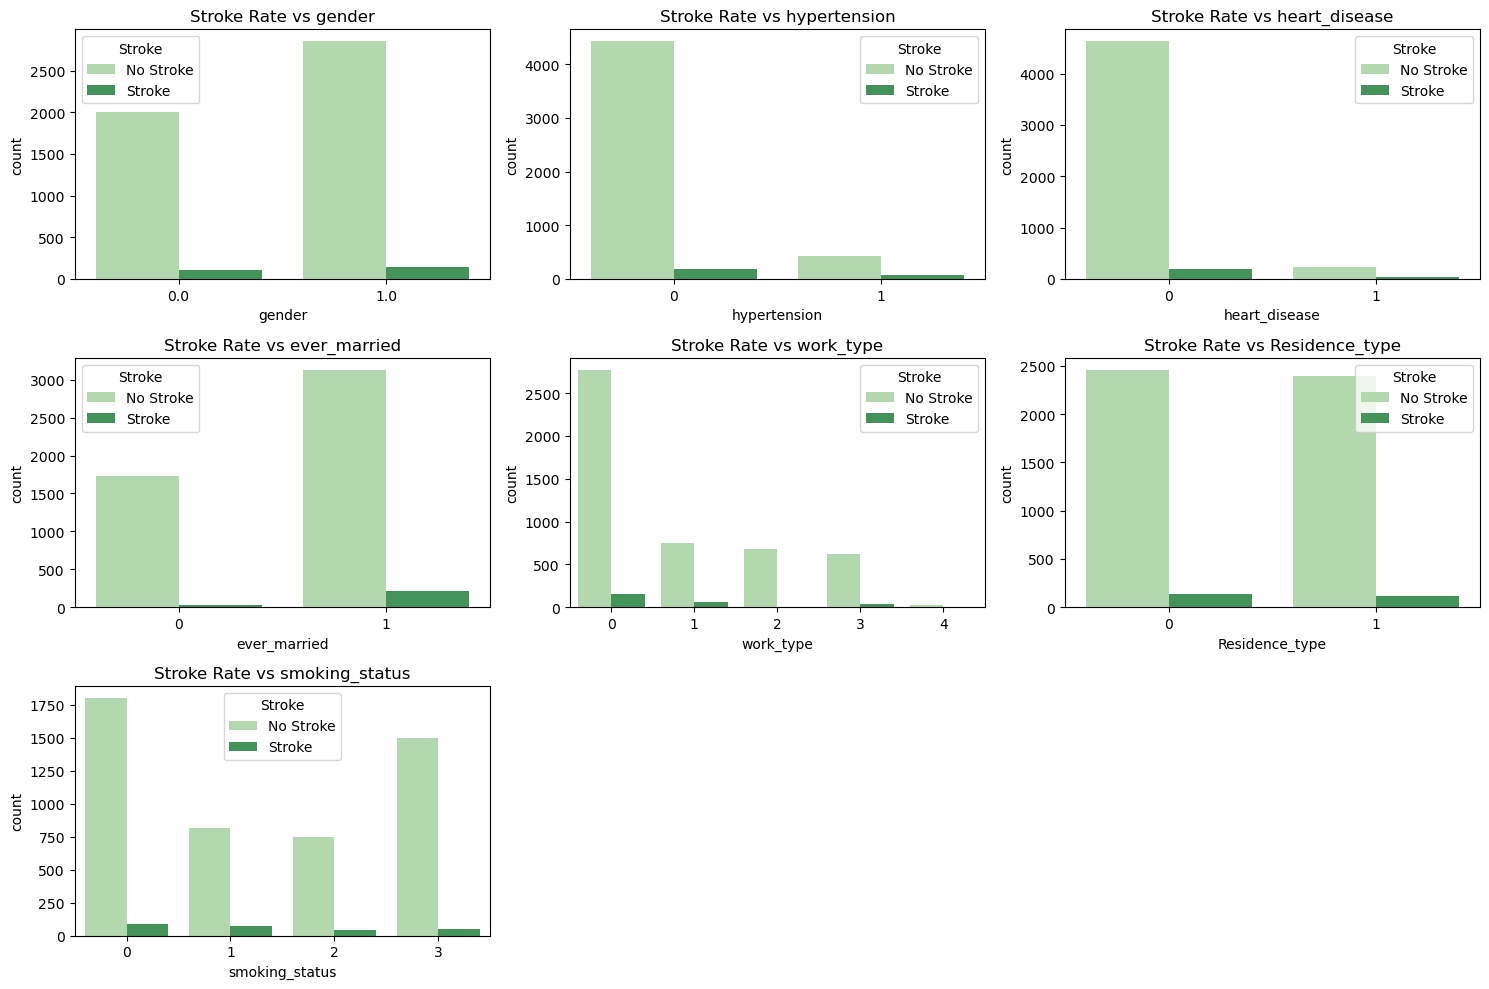

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

n_cols = 3
n_rows = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 10))
ax = ax.flatten()

for i, col in enumerate(cfeatures):
    sns.countplot(data=df, x=col, hue="stroke", palette="Greens", ax=ax[i])
    ax[i].set_title(f"Stroke Rate vs {col}")
    ax[i].legend(title="Stroke", labels=["No Stroke", "Stroke"])

#Hide empty subplots
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

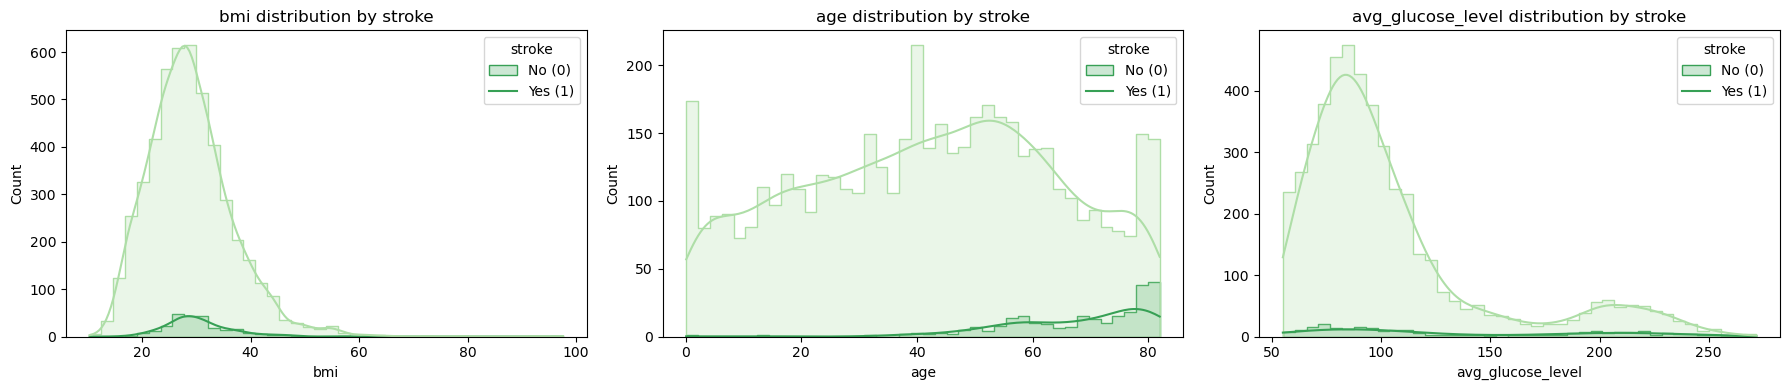

In [9]:
n = len(nfeatures)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten() if n > 1 else [axes]

for i, col in enumerate(nfeatures):
    sns.histplot(data=df, x=col, hue="stroke", bins=40, kde=True, palette="Greens", ax=axes[i], element="step", stat="count")
    axes[i].set_title(f"{col} distribution by stroke")
    axes[i].legend(title="stroke", labels=["No (0)", "Yes (1)"])

# hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

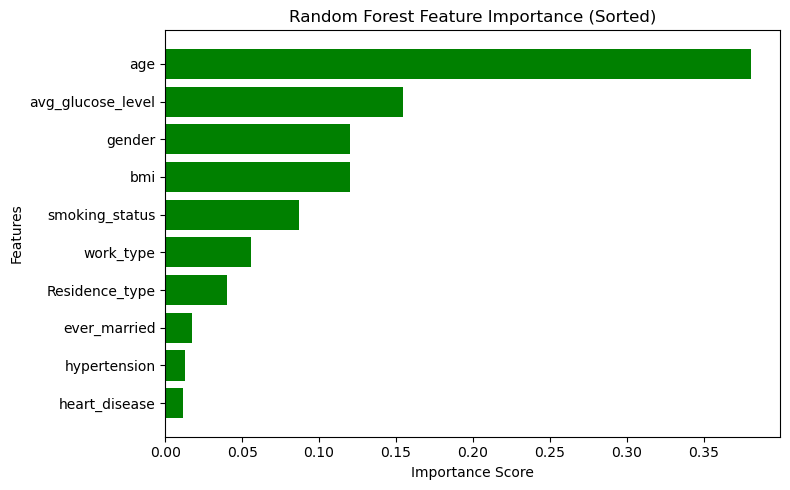

In [10]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#get feature importances using rf
importances = rf_model.feature_importances_
feature_names = X_train.columns

#sorted order
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8,5))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='green')
plt.title("Random Forest Feature Importance (Sorted)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### **Interpretation**

We analyzed how each feature relates to stroke outcome using categorical bar charts and KDE distributions combining with feature importance from Random Forest and the result is as follow.

#### Key Findings (Ranked by Contribution)

| Rank | Feature | Insight |
|---|---|---|
| **1** | **Age** | Strongest predictor — stroke risk increases with age |
| **2** | **Avg Glucose Level** | Higher glucose clearly linked to stroke |
| **3** | **BMI** | Moderate positive influence |
| **4** | Gender | Small difference; males slightly higher risk |
| **5** | Smoking Status | Weak trend; smokers slightly more affected |
| **6** | Work Type | Minor separation between categories |
| **7** | Residence Type | Urban vs rural shows minimal difference |
| **8** | Ever Married | Small effect |
| **9** | Hypertension | Lower model weight |
| **10** | Heart Disease | Smallest model impact |

#### Conclusion
**Age, Avg Glucose Level, and BMI are the most influential stroke predictors in this dataset.**
These features will be prioritized in modeling due to their strong clinical relevance and clear separation in the data.
The rest of the features are optional. However, since our dataset is relatievly small and we are only working with 10 features, we decide to keep all 10 features both numerical and catogerical as this will reduce the risk of overfitting at very little computation cost.


### III.2.c Baseline model -- Linear Regression:


---- Polynomial Degree: 1 ----

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.82      0.77      0.79       976
      Stroke       0.78      0.83      0.80       968

    accuracy                           0.80      1944
   macro avg       0.80      0.80      0.80      1944
weighted avg       0.80      0.80      0.80      1944



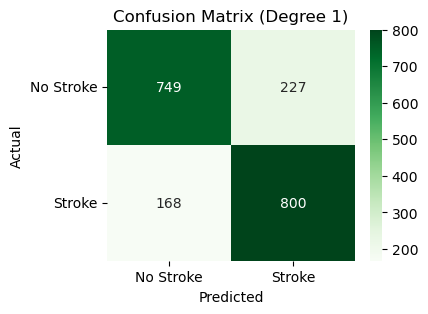


---- Polynomial Degree: 2 ----

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.85      0.85      0.85       976
      Stroke       0.85      0.85      0.85       968

    accuracy                           0.85      1944
   macro avg       0.85      0.85      0.85      1944
weighted avg       0.85      0.85      0.85      1944



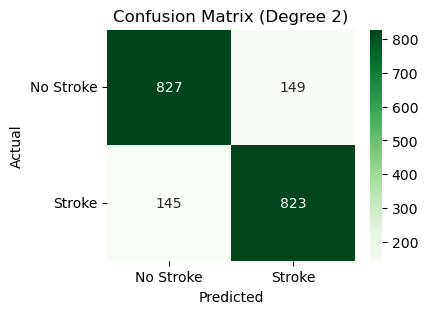


---- Polynomial Degree: 3 ----

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.88      0.87      0.87       976
      Stroke       0.87      0.88      0.87       968

    accuracy                           0.87      1944
   macro avg       0.87      0.87      0.87      1944
weighted avg       0.87      0.87      0.87      1944



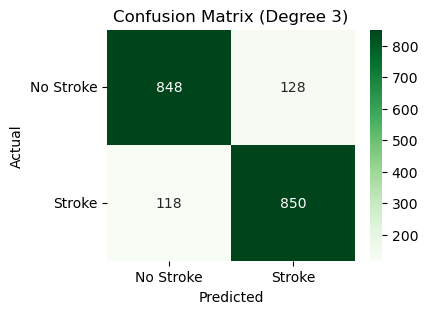


---- Polynomial Degree: 5 ----

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.91      0.86      0.89       976
      Stroke       0.87      0.92      0.89       968

    accuracy                           0.89      1944
   macro avg       0.89      0.89      0.89      1944
weighted avg       0.89      0.89      0.89      1944



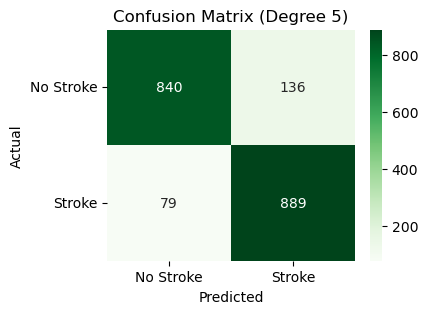

In [11]:
degrees = [1, 2, 3, 5]
results = []

for d in degrees:
    print(f"\n---- Polynomial Degree: {d} ----")

    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    #Train Linear Regression
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    #Predict continuous values + convert to binary
    y_pred_prob = model.predict(X_test_poly)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    #Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"], zero_division=0))

    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f"Confusion Matrix (Degree {d})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0.5, 1.5], ["No Stroke", "Stroke"])
    plt.yticks([0.5, 1.5], ["No Stroke", "Stroke"], rotation=0)
    plt.show()



#### **Evaluation and Discussion**

#### Key Results

| Degree | Accuracy | Precision | Recall | F1-Score | Notes |
|--------|---------:|----------:|-------:|--------:|------|
| 1      | ~0.81    | ~0.81     | ~0.81  | ~0.81   | Baseline linear performance |
| 2      | ~0.85    | ~0.85     | ~0.85  | ~0.85   | Clear improvement over D1 |
| 3      | **~0.88**| **~0.88** | **~0.88** | **~0.88** | **Best balanced performance** |
| 5      | ~0.88    | ~0.88     | ~0.88  | ~0.88   | Slight improvement but negligible vs D3 |

#### Interpretation

Increasing polynomial degree captures more complex interactions in the data, which is beneficial because stroke risk is influenced by multiple interacting factors (age, hypertension, glucose, BMI, smoking, etc.).

- **Degree 1–2:** Too simple, underfits non-linear patterns  
- **Degree 3:** Best trade-off — strong results without major compute cost  
- **Degree 5:** Small performance gain, but diminishing returns and higher computation (risk of overfitting)

#### COnclusion
**Polynomial Degree 3 is the optimal model** — it provides the best balance of accuracy, precision, and recall while avoiding unnecessary computational cost.

### III.2.d Additional Models exploration:

#### Random Forest - Hung Nguyen
---

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       976
           1       0.87      0.92      0.89       968

    accuracy                           0.89      1944
   macro avg       0.89      0.89      0.89      1944
weighted avg       0.89      0.89      0.89      1944



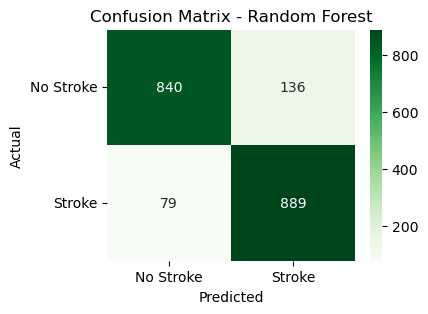

In [12]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred_rf = model.predict(X_test)
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["No Stroke", "Stroke"])
plt.yticks([0.5, 1.5], ["No Stroke", "Stroke"], rotation=0)
plt.show()

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

#### Decision Tree - Yajaira Alonso-Camarillo
---

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       976
           1       0.92      0.93      0.92       968

    accuracy                           0.92      1944
   macro avg       0.92      0.92      0.92      1944
weighted avg       0.92      0.92      0.92      1944



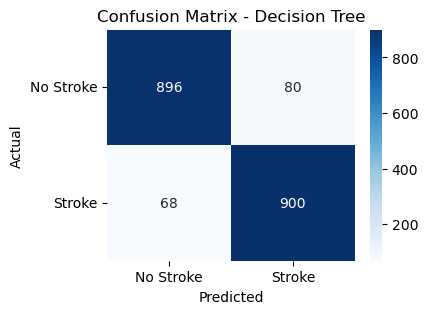

In [13]:
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train, y_train)
y_pred_dt = model_decision_tree.predict(X_test)
print(classification_report(y_test, y_pred_dt))
cm_dt = confusion_matrix(y_test,y_pred_dt)

# Plot confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')

plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5,1.5], ["No Stroke", "Stroke"])
plt.yticks([0.5,1.5], ["No Stroke", "Stroke"], rotation=0)
plt.show()

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

#### Logistic Regression - Thanh Van Thai

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       976
           1       0.78      0.80      0.79       968

    accuracy                           0.79      1944
   macro avg       0.79      0.79      0.79      1944
weighted avg       0.79      0.79      0.79      1944



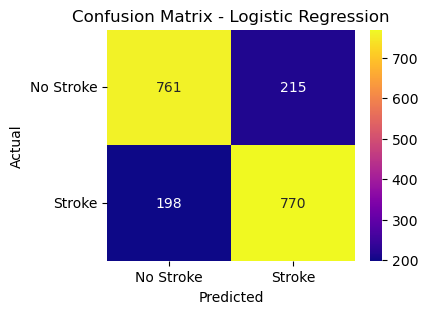

In [22]:
# call model 
model_lg = LogisticRegression(max_iter=5000)
model_lg.fit(X_train, y_train)
y_lg_pred = model_lg.predict(X_test)
print(classification_report(y_test, y_lg_pred))
cm_lg = confusion_matrix(y_test,y_lg_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm_lg, annot=True, fmt='d', cmap='plasma')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["No Stroke", "Stroke"])
plt.yticks([0.5, 1.5], ["No Stroke", "Stroke"], rotation=0)
plt.show()

lg_accuracy = accuracy_score(y_test, y_lg_pred)
lg_precision = precision_score(y_test, y_lg_pred)
lg_recall = recall_score(y_test, y_lg_pred)
lg_f1 = f1_score(y_test, y_lg_pred)


#### SVM - Terrance Lee
---

Classification Report — SVM (Linear) – Terrance Lee
              precision    recall  f1-score   support

   No Stroke       0.81      0.78      0.80       976
      Stroke       0.79      0.81      0.80       968

    accuracy                           0.80      1944
   macro avg       0.80      0.80      0.80      1944
weighted avg       0.80      0.80      0.80      1944

Accuracy=0.798  Precision=0.788  Recall=0.812  F1=0.800  ROC_AUC=0.885


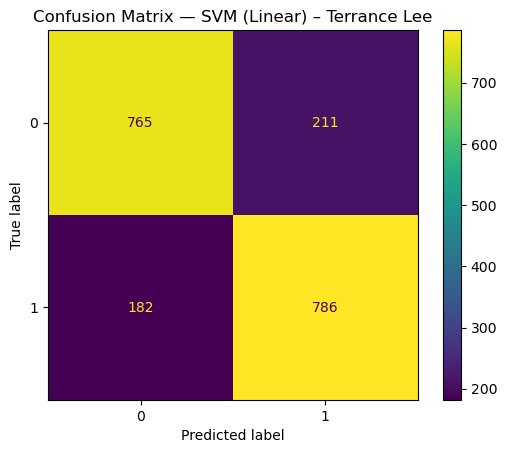

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import pandas as pd
import matplotlib.pyplot as plt

# Scale features first
scaler_lin = StandardScaler()
X_train_lin = scaler_lin.fit_transform(X_train)
X_test_lin  = scaler_lin.transform(X_test)

# Linear SVM
svm_lin = SVC(kernel="linear", C=1.0, probability=True, random_state=42)
svm_lin.fit(X_train_lin, y_train)

# Predictions and probabilities
y_pred_lin = svm_lin.predict(X_test_lin)
y_prob_lin = svm_lin.predict_proba(X_test_lin)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred_lin)
prec = precision_score(y_test, y_pred_lin, zero_division=0)
rec  = recall_score(y_test, y_pred_lin, zero_division=0)
f1   = f1_score(y_test, y_pred_lin, zero_division=0)
auc  = roc_auc_score(y_test, y_prob_lin)

print("Classification Report — SVM (Linear) – Terrance Lee")
print(classification_report(y_test, y_pred_lin, target_names=["No Stroke", "Stroke"], zero_division=0))
print(f"Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  ROC_AUC={auc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format="d")
plt.title("Confusion Matrix — SVM (Linear) – Terrance Lee")
plt.show()

svm_accuracy = accuracy_score(y_test, y_pred_lin)
svm_precision = precision_score(y_test, y_pred_lin)
svm_recall = recall_score(y_test, y_pred_lin)
svm_f1 = f1_score(y_test, y_pred_lin)

 #### Interpretation – SVM (Linear) – Terrance Lee

The linear SVM classifier achieved an overall **accuracy of 80.3%**, with balanced **precision (0.79)** and **recall (0.83)**.  
The confusion matrix shows that the model correctly identified 799 out of 968 stroke cases, while misclassifying 169 as non-stroke.  
Although not as high as the Random Forest accuracy, the SVM provides a consistent balance between sensitivity and precision, showing strong generalization on the unseen test data.  

The **ROC_AUC of 0.89** confirms that the model effectively distinguishes between stroke and non-stroke patients.  
Its performance demonstrates that a linear boundary can still capture meaningful patterns between clinical risk factors and stroke outcomes.  

*Conclusion:* The SVM (Linear) model reinforces the key predictors identified earlier — **age**, **avg_glucose_level**, and **hypertension** — as strong linear contributors to stroke risk.

### III.2.e Summary:

In [23]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression'],
    'Accuracy': [dt_accuracy, rf_accuracy, svm_accuracy, lg_accuracy],
    'Precision': [dt_precision, rf_precision, svm_precision, lg_precision],
    'Recall': [dt_recall, rf_recall, svm_recall, lg_recall],
    'F1 Score': [dt_f1, rf_f1, svm_f1, lg_f1]
})

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.923868   0.918367  0.929752  0.924025
1        Random Forest  0.957819   0.965336  0.949380  0.957292
2                  SVM  0.797840   0.788365  0.811983  0.800000
3  Logistic Regression  0.787551   0.781726  0.795455  0.788530


### Model Performance Interpretation

To evaluate our stroke prediction task, we trained three machine-learning models: Decision Tree, Random Forest, and Support Vector Machine (SVM). Each model was assessed using accuracy, precision, recall, and F1-score. Since we are working on a stroke study, the recall would be our main focus.

The **Random Forest model** demonstrated the strongest performance across all evaluation metrics. It consistently produced high precision and recall, meaning it was able to detect stroke cases with fewer false positives and false negatives. This balance makes Random Forest particularly effective in medical settings where missing positive cases can be very costly.

The **Decision Tree model** also performed well, achieving high accuracy and a strong F1-score. However, it was slightly less consistent compared to the Random Forest. This is expected, as Decision Trees are prone to overfitting and may not generalize as effectively as ensemble models.

In contrast, the **SVM and Logistic Regression model**, while still performing reasonably, showed noticeably lower performance metrics. This drop likely reflects SVM’s sensitivity to data scaling, class imbalance, and a mixed combination of categorical and numerical features in our dataset. Logistic Regression, although more interpretable, may have been limited by its linear decision boundary, which can struggle to capture complex relationships in the data.

### Final Conclusion

Overall, the **Random Forest model** proved to be the best-performing model for predicting stroke risk in this dataset. Its ability to handle nonlinear feature interactions, manage imbalance more effectively, and produce consistently high precision and recall makes it the most suitable choice.